In [11]:
import pandas as pd

# 1. ВЫГРУЗКА ДАННЫХ

financial = pd.read_csv('financial_data.csv')
prolong = pd.read_csv('prolongations.csv')

print(f"financial: {financial.shape}, prolong: {prolong.shape}")

# смотрим данные
financial
prolong

# 2. ФИКСИМ РЕГИСТР МЕСЯЦЕВ в prolong
# Словарь для преобразования регистра

month_fix = {
    'ноябрь 2022': 'Ноябрь 2022', 'декабрь 2022': 'Декабрь 2022',
    'январь 2023': 'Январь 2023', 'февраль 2023': 'Февраль 2023',
    'март 2023': 'Март 2023', 'апрель 2023': 'Апрель 2023',
    'май 2023': 'Май 2023', 'июнь 2023': 'Июнь 2023',
    'июль 2023': 'Июль 2023', 'август 2023': 'Август 2023',
    'сентябрь 2023': 'Сентябрь 2023', 'октябрь 2023': 'Октябрь 2023',
    'ноябрь 2023': 'Ноябрь 2023', 'декабрь 2023': 'Декабрь 2023'
}

prolong['month'] = prolong['month'].map(month_fix)

# 3. ОЧИСТКА ДАННЫХ
""" В данных financial видно, что числа содержат неразрывные пробелы (\xa0), а также по условиям в колонках с месяцами
могут также встречаться такие значения: 'в ноль' –  отгрузка проекта в данном месяце равна 0, значит для коэффициента
пролонгации нужно взять отгрузку предыдущего месяца (только если все части оплаты равны 0); 'стоп' – проект закончился
до истечения срока договора, если у проекта есть 'стоп' в последний месяц реализации или ранее, то такой проект исключаем 
из пролонгаций; 'end' – аналогично 'стоп'."""

# Функция для очитски данных 

def clean_number(x):
    if pd.isna(x) or x in ['стоп', 'end', 'в ноль']:
        return 0
    if isinstance(x, str):
        clean_x = x.replace(' ', '').replace('\xa0', '').replace(',', '.')
        try:
            return float(clean_x)
        except:
            return 0
    return x

all_months = ['Ноябрь 2022', 'Декабрь 2022', 'Январь 2023', 'Февраль 2023', 
             'Март 2023', 'Апрель 2023', 'Май 2023', 'Июнь 2023', 
             'Июль 2023', 'Август 2023', 'Сентябрь 2023', 'Октябрь 2023',
             'Ноябрь 2023', 'Декабрь 2023', 'Январь 2024', 'Февраль 2024']

for month in all_months:
    financial[month] = financial[month].apply(clean_number)


# 4. РАСЧЕТ КОЭФФИЦИЕНТОВ ПО МЕСЯЦАМ ДЛЯ КАЖДОГО МЕНЕДЖЕРА

# Месяцы для анализа (2023 год)
analysis_months = ['Февраль 2023', 'Март 2023', 'Апрель 2023', 'Май 2023', 
                  'Июнь 2023', 'Июль 2023', 'Август 2023', 'Сентябрь 2023',
                  'Октябрь 2023', 'Ноябрь 2023', 'Декабрь 2023']

managers = [m for m in prolong['AM'].unique() if m != 'без А/М']


# Списки для результатов
monthly_manager_results = []  # K1 каждого менеджера по месяцам
department_monthly_results = []  # K1 отдела по месяцам

# Проходим по каждому месяцу оценки
for eval_month in analysis_months:
       
    # Находим предыдущий месяц для K1
    month_index = all_months.index(eval_month)
    prev_month = all_months[month_index - 1]
    
    monthly_department_k1 = 0
    monthly_department_total = 0
    monthly_department_renewed = 0
    monthly_department_projects = 0
    
    # Считаем для каждого менеджера
    for manager in managers:
        # Проекты менеджера, завершившиеся в предыдущем месяце
        manager_projects = prolong[
            (prolong['AM'] == manager) & 
            (prolong['month'] == prev_month)
        ]
        
        manager_total = 0
        manager_renewed = 0
        manager_projects_count = len(manager_projects)
        
        for _, project in manager_projects.iterrows():
            project_id = project['id']
            
            # Находим проект в financial
            project_data = financial[financial['id'] == project_id]
            if len(project_data) == 0:
                continue
                
            project_row = project_data.iloc[0]
            
            # Сумма в месяц завершения
            completion_amount = project_row[prev_month]
            manager_total += completion_amount
            
            # Сумма в месяце оценки
            renewed_amount = project_row[eval_month]
            manager_renewed += renewed_amount
        
        # Считаем K1 для менеджера
        manager_k1 = manager_renewed / manager_total if manager_total > 0 else 0
        
        # Добавляем в результаты по менеджеру
        monthly_manager_results.append({
            'Месяц': eval_month,
            'Менеджер': manager,
            'K1': manager_k1,
            'Количество_проектов': manager_projects_count,
            'Сумма_отгрузки': manager_total,
            'Пролонгировано': manager_renewed
        })
        
        # Суммируем для отдела
        monthly_department_total += manager_total
        monthly_department_renewed += manager_renewed
        monthly_department_projects += manager_projects_count
    
    # Считаем K1 для отдела за месяц
    department_k1 = monthly_department_renewed / monthly_department_total if monthly_department_total > 0 else 0
    
    department_monthly_results.append({
        'Месяц': eval_month,
        'K1': department_k1,
        'Количество_проектов': monthly_department_projects,
        'Сумма_отгрузки': monthly_department_total,
        'Пролонгировано': monthly_department_renewed
    })



# 5. ФОРМИРУЕМ ОТЧЕТЫ

# Создаем DataFrames
monthly_manager_df = pd.DataFrame(monthly_manager_results)
department_monthly_df = pd.DataFrame(department_monthly_results)

# Годовой отчет по менеджерам
yearly_manager_report = monthly_manager_df.groupby('Менеджер').agg({
    'K1': 'mean',
    'Количество_проектов': 'sum',
    'Сумма_отгрузки': 'sum',
    'Пролонгировано': 'sum'
}).reset_index()

yearly_manager_report = yearly_manager_report.sort_values('K1', ascending=False)

# 6. ВЫВОД РЕЗУЛЬТАТОВ
print("\n" + "="*70)
print("ПОЛНЫЙ ОТЧЕТ ПО ПРОЛОНГАЦИЯМ 2023")
print("="*70)

print(f"\n ОТДЕЛ В ЦЕЛОМ ЗА ГОД:")
avg_k1_department = yearly_manager_report['K1'].mean()
print(f"• Средний K1: {avg_k1_department:.1%}")
print(f"• Всего проектов: {yearly_manager_report['Количество_проектов'].sum()}")
print(f"• Общая сумма: {yearly_manager_report['Сумма_отгрузки'].sum():,.0f} руб.")

print(f"\n ДИНАМИКА ОТДЕЛА ПО МЕСЯЦАМ:")
for _, row in department_monthly_df.iterrows():
    print(f"  {row['Месяц']}: K1 = {row['K1']:.1%} ({row['Количество_проектов']} проектов)")

print(f"\n ГОДОВЫЕ РЕЗУЛЬТАТЫ МЕНЕДЖЕРОВ:")
for i, row in yearly_manager_report.iterrows():
    print(f"  {row['Менеджер']:.<25} K1: {row['K1']:>6.1%}")

# 7. ПОМЕСЯЧНЫЕ РЕЗУЛЬТАТЫ КАЖДОГО МЕНЕДЖЕРА
print(f"\n ПОМЕСЯЧНАЯ СТАТИСТИКА МЕНЕДЖЕРОВ:")

for manager in managers:
    print(f"\n{manager}:")
    manager_monthly = monthly_manager_df[monthly_manager_df['Менеджер'] == manager]
    
    for month in analysis_months:
        month_data = manager_monthly[manager_monthly['Месяц'] == month]
        if len(month_data) > 0:
            k1 = month_data['K1'].iloc[0]
            projects = month_data['Количество_проектов'].iloc[0]
            print(f"  {month}: K1 = {k1:.1%} ({projects} проектов)")
        else:
            print(f"  {month}: нет данных")

# 8. СОХРАНЕНИЕ В EXCEL

with pd.ExcelWriter('аналитический_отчет.xlsx') as writer:
    # 1. Менеджеры за год (сводка)
    yearly_manager_report.to_excel(writer, sheet_name='Менеджеры_годовые', index=False)
    
    # 2. Детали по месяцам для каждого менеджера
    monthly_manager_df.to_excel(writer, sheet_name='Менеджеры_по_месяцам', index=False)
    
    # 3. Отдел по месяцам
    department_monthly_df.to_excel(writer, sheet_name='Отдел_по_месяцам', index=False)
    
    # 4. Сводная таблица по менеджерам и месяцам
    pivot_table = monthly_manager_df.pivot_table(
        values='K1', 
        index='Менеджер', 
        columns='Месяц', 
        aggfunc='first'
    ).round(4)
    
    pivot_table.to_excel(writer, sheet_name='Сводная_K1_по_месяцам')
    
    # 5. Сводка
    best_month = department_monthly_df.loc[department_monthly_df['K1'].idxmax()]
    worst_month = department_monthly_df.loc[department_monthly_df['K1'].idxmin()]
    
    summary_data = {
        'Показатель': [
            'Средний K1 отдела за год',
            'Лучший менеджер года',
            'Лучший K1 менеджера',
            'Лучший месяц для отдела', 
            'Лучший K1 месяца',
            'Всего проектов за год',
            'Общая сумма отгрузки'
        ],
        'Значение': [
            f"{avg_k1_department:.1%}",
            yearly_manager_report.iloc[0]['Менеджер'],
            f"{yearly_manager_report.iloc[0]['K1']:.1%}",
            best_month['Месяц'],
            f"{best_month['K1']:.1%}",
            f"{yearly_manager_report['Количество_проектов'].sum()}",
            f"{yearly_manager_report['Сумма_отгрузки'].sum():,.0f} руб."
        ]
    }
    pd.DataFrame(summary_data).to_excel(writer, sheet_name='Итоговая_сводка', index=False)


print("\n ОТЧЕТ:")
print("1. Менеджеры_годовые - K1 каждого менеджера за год")
print("2. Менеджеры_по_месяцам - K1 каждого менеджера по КАЖДОМУ месяцу")
print("3. Отдел_по_месяцам - K1 отдела по месяцам")
print("4. Сводная_K1_по_месяцам - таблица K1 всех менеджеров по месяцам")
print("5. Итоговая_сводка - ключевые показатели")

financial: (451, 19), prolong: (477, 3)

ПОЛНЫЙ ОТЧЕТ ПО ПРОЛОНГАЦИЯМ 2023

 ОТДЕЛ В ЦЕЛОМ ЗА ГОД:
• Средний K1: 36.3%
• Всего проектов: 316
• Общая сумма: 23,714,029 руб.

 ДИНАМИКА ОТДЕЛА ПО МЕСЯЦАМ:
  Февраль 2023: K1 = 80.2% (20 проектов)
  Март 2023: K1 = 57.3% (28 проектов)
  Апрель 2023: K1 = 60.6% (33 проектов)
  Май 2023: K1 = 55.0% (28 проектов)
  Июнь 2023: K1 = 31.2% (22 проектов)
  Июль 2023: K1 = 55.0% (31 проектов)
  Август 2023: K1 = 47.5% (22 проектов)
  Сентябрь 2023: K1 = 35.8% (26 проектов)
  Октябрь 2023: K1 = 81.4% (42 проектов)
  Ноябрь 2023: K1 = 49.5% (24 проектов)
  Декабрь 2023: K1 = 50.2% (40 проектов)

 ГОДОВЫЕ РЕЗУЛЬТАТЫ МЕНЕДЖЕРОВ:
  Михайлов Андрей Сергеевич K1:  66.1%
  Васильев Артем Александрович K1:  59.6%
  Соколова Анастасия Викторовна K1:  56.6%
  Смирнова Ольга Владимировна K1:  39.8%
  Попова Екатерина Николаевна K1:  37.4%
  Иванова Мария Сергеевна.. K1:  35.7%
  Кузнецов Михаил Иванович. K1:  21.4%
  Петрова Анна Дмитриевна.. K1:  10.1%
  Федо

**Чтоб сделать данные более наглядными делаем сводный отчёт**

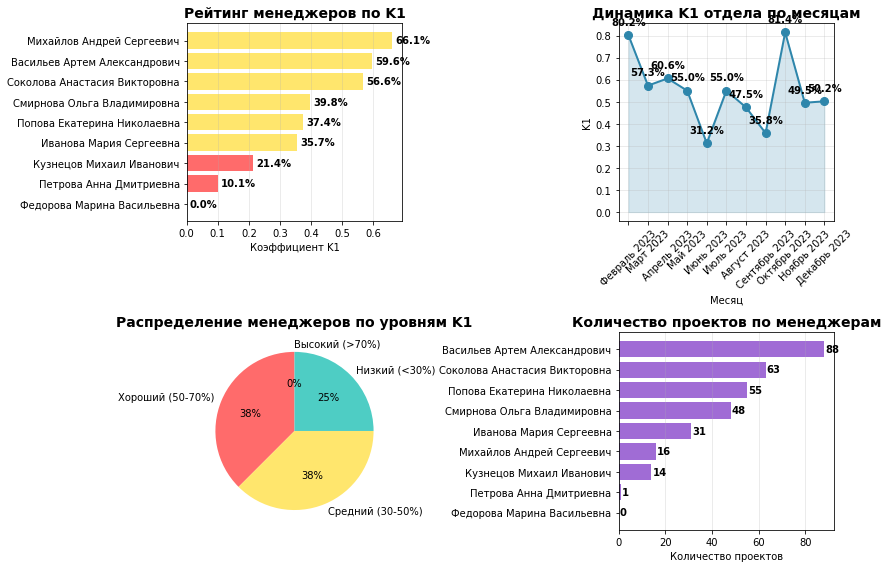

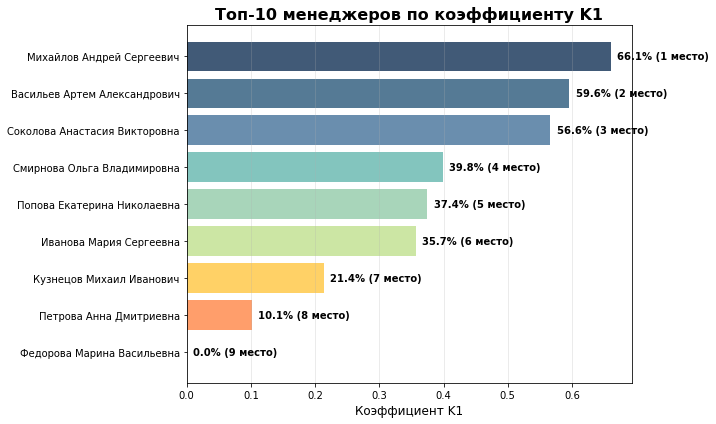


 ЧТО В ОТЧЕТЕ:
1. Сводка - ключевые показатели и достижения
2. Рейтинг менеджеров - кто работает лучше всего
3. Динамика по месяцам - как менялись показатели
4. K1 по менеджерам и месяцам - детальная таблица
5. Аналитика и рекомендации - выводы и предложения


In [14]:
# EXCEL ОТЧЕТ С ГРАФИКАМИ ДЛЯ РУКОВОДИТЕЛЯ

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Загружаем результаты анализа

monthly_data = pd.read_excel('аналитический_отчет.xlsx', sheet_name='Менеджеры_по_месяцам')
yearly_data = pd.read_excel('аналитический_отчет.xlsx', sheet_name='Менеджеры_годовые')
dept_monthly = pd.read_excel('аналитический_отчет.xlsx', sheet_name='Отдел_по_месяцам')

# 1. ГРАФИК: РЕЙТИНГ МЕНЕДЖЕРОВ ПО K1
plt.figure(figsize=(12, 8))

# Сортируем менеджеров по K1
yearly_sorted = yearly_data.sort_values('K1', ascending=True)

# График 1 - K1 по менеджерам
plt.subplot(2, 2, 1)
bars = plt.barh(yearly_sorted['Менеджер'], yearly_sorted['K1'], 
                color=['#FF6B6B' if k1 < 0.3 else '#4ECDC4' if k1 > 0.7 else '#FFE66D' for k1 in yearly_sorted['K1']])
plt.title('Рейтинг менеджеров по K1', fontsize=14, fontweight='bold')
plt.xlabel('Коэффициент K1')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения на столбцы
for bar, k1 in zip(bars, yearly_sorted['K1']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{k1:.1%}', ha='left', va='center', fontweight='bold')

# 2. ГРАФИК: ДИНАМИКА K1 ОТДЕЛА ПО МЕСЯЦАМ
plt.subplot(2, 2, 2)
months = dept_monthly['Месяц']
k1_values = dept_monthly['K1']

plt.plot(months, k1_values, marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.fill_between(months, k1_values, alpha=0.2, color='#2E86AB')
plt.title('Динамика K1 отдела по месяцам', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('K1')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Добавляем значения точек
for i, (month, k1) in enumerate(zip(months, k1_values)):
    plt.annotate(f'{k1:.1%}', (month, k1), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontweight='bold')

# 3. ГРАФИК: РАСПРЕДЕЛЕНИЕ МЕНЕДЖЕРОВ ПО УРОВНЯМ K1
plt.subplot(2, 2, 3)
bins = [0, 0.3, 0.5, 0.7, 1.0]
labels = ['Низкий (<30%)', 'Средний (30-50%)', 'Хороший (50-70%)', 'Высокий (>70%)']
k1_levels = pd.cut(yearly_data['K1'], bins=bins, labels=labels)
level_counts = k1_levels.value_counts()

colors = ['#FF6B6B', '#FFE66D', '#4ECDC4', '#1A936F']
plt.pie(level_counts.values, labels=level_counts.index, autopct='%1.0f%%', 
        colors=colors, startangle=90)
plt.title('Распределение менеджеров по уровням K1', fontsize=14, fontweight='bold')

# 4. ГРАФИК: КОЛИЧЕСТВО ПРОЕКТОВ ПО МЕНЕДЖЕРАМ
plt.subplot(2, 2, 4)
projects_sorted = yearly_data.sort_values('Количество_проектов', ascending=True)
plt.barh(projects_sorted['Менеджер'], projects_sorted['Количество_проектов'], color='#A06CD5')
plt.title('Количество проектов по менеджерам', fontsize=14, fontweight='bold')
plt.xlabel('Количество проектов')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения
for i, (manager, projects) in enumerate(zip(projects_sorted['Менеджер'], projects_sorted['Количество_проектов'])):
    plt.text(projects + 0.5, i, str(projects), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('графики_пролонгации.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. ГРАФИК: ТОП-10 МЕНЕДЖЕРОВ (для презентации)
plt.figure(figsize=(10, 6))
top_10 = yearly_data.nlargest(10, 'K1').sort_values('K1', ascending=True)

colors = ['#FF6B6B', '#FF9E6B', '#FFD166', '#CCE6A4', '#A8D5BA', 
          '#83C5BE', '#6A8EAE', '#557A95', '#415A77', '#2E4A6B']

bars = plt.barh(top_10['Менеджер'], top_10['K1'], color=colors)
plt.title('Топ-10 менеджеров по коэффициенту K1', fontsize=16, fontweight='bold')
plt.xlabel('Коэффициент K1', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Добавляем значения и рейтинг
for i, (bar, k1, manager) in enumerate(zip(bars, top_10['K1'], top_10['Менеджер'])):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{k1:.1%} ({len(top_10)-i} место)', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('топ10_менеджеров.png', dpi=300, bbox_inches='tight')
plt.show()


# СОЗДАЕМ EXCEL ОТЧЕТ
with pd.ExcelWriter('Отчет_с_графиками_2023.xlsx') as writer:
    
    # 1. СВОДКА С ГРАФИКАМИ
    
    avg_k1 = yearly_data['K1'].mean()
    total_projects = yearly_data['Количество_проектов'].sum()
    total_amount = yearly_data['Сумма_отгрузки'].sum()
    
    summary_data = {
        'Ключевые показатели отдела': [
            f'Средний K1 за 2023 год: {avg_k1:.1%}',
            f'Всего завершенных проектов: {total_projects}',
            f'Общая сумма отгрузки: {total_amount:,.0f} руб.',
            f'Пролонгировано: {yearly_data["Пролонгировано"].sum():,.0f} руб.',
            f'Эффективность пролонгации: {(yearly_data["Пролонгировано"].sum()/total_amount):.1%}',
            '',
            'Лучшие результаты:',
            f'• {yearly_data.iloc[0]["Менеджер"]} - {yearly_data.iloc[0]["K1"]:.1%}',
            f'• {yearly_data.iloc[1]["Менеджер"]} - {yearly_data.iloc[1]["K1"]:.1%}' if len(yearly_data) > 1 else '',
            f'• {yearly_data.iloc[2]["Менеджер"]} - {yearly_data.iloc[2]["K1"]:.1%}' if len(yearly_data) > 2 else '',
            '',
            'Целевые показатели:',
            '• K1 > 70% - отличный результат',
            '• K1 > 50% - удовлетворительно',
            '• K1 < 30% - требует внимания'
        ]
    }
    
    pd.DataFrame(summary_data).to_excel(writer, sheet_name='Сводка', index=False)
    
    # 2. РЕЙТИНГ МЕНЕДЖЕРОВ
      
    yearly_ranked = yearly_data.copy()
    yearly_ranked['Рейтинг'] = range(1, len(yearly_ranked) + 1)
    yearly_ranked['K1_проценты'] = yearly_ranked['K1'].apply(lambda x: f'{x:.1%}')
    yearly_ranked['Эффективность'] = (yearly_ranked['Пролонгировано'] / yearly_ranked['Сумма_отгрузки']).apply(lambda x: f'{x:.1%}')
    
    display_cols = ['Рейтинг', 'Менеджер', 'K1_проценты', 'Количество_проектов', 
                   'Сумма_отгрузки', 'Пролонгировано', 'Эффективность']
    
    yearly_ranked[display_cols].to_excel(writer, sheet_name='Рейтинг менеджеров', index=False)
    
    # 3. ДИНАМИКА ПО МЕСЯЦАМ
       
    dept_display = dept_monthly.copy()
    dept_display['K1_проценты'] = dept_display['K1'].apply(lambda x: f'{x:.1%}')
    dept_display['Сумма_отгрузки_руб'] = dept_display['Сумма_отгрузки'].apply(lambda x: f'{x:,.0f} руб.')
    dept_display['Пролонгировано_руб'] = dept_display['Пролонгировано'].apply(lambda x: f'{x:,.0f} руб.')
    
    dept_display[['Месяц', 'K1_проценты', 'Количество_проектов', 
                  'Сумма_отгрузки_руб', 'Пролонгировано_руб']].to_excel(writer, sheet_name='Динамика по месяцам', index=False)
    
    # 4. ДЕТАЛИ ПО МЕНЕДЖЕРАМ
      
    pivot = monthly_data.pivot_table(
        values='K1', 
        index='Менеджер', 
        columns='Месяц', 
        aggfunc='first'
    ).round(4)
    
    # Форматируем в проценты
    pivot_percent = pivot.applymap(lambda x: f'{x:.1%}' if pd.notna(x) else '-')
    pivot_percent.to_excel(writer, sheet_name='K1 по менеджерам и месяцам')
    
    # 5. АНАЛИТИКА
      
    analysis_data = {
        'Анализ и рекомендации': [
            'ВЫВОДЫ ПО АНАЛИЗУ:',
            f'• Отдел показывает среднюю эффективность пролонгации {avg_k1:.1%}',
            f'• {len(yearly_data[yearly_data["K1"] > 0.7])} менеджеров имеют K1 > 70%',
            f'• {len(yearly_data[yearly_data["K1"] < 0.3])} менеджеров требуют внимания (K1 < 30%)',
            f'• Лучший месяц: {dept_monthly.loc[dept_monthly["K1"].idxmax(), "Месяц"]}',
            f'• Худший месяц: {dept_monthly.loc[dept_monthly["K1"].idxmin(), "Месяц"]}',
            '',
            'РЕКОМЕНДАЦИИ:',
            '• Провести разбор кейсов топ-менеджеров',
            '• Организовать обучение для менеджеров с низким K1',
            '• Внедрить ежемесячный мониторинг показателей',
            '• Разработать программу мотивации за пролонгации',
            '',
            'ПРЕДЛОЖЕНИЯ:',
            '• Создать базу успешных практик пролонгации',
            '• Внедрить систему напоминаний клиентам',
            '• Разработать скрипты повторного контакта',
            '• Провести тренинг по техникам удержания клиентов'
        ]
    }
    
    pd.DataFrame(analysis_data).to_excel(writer, sheet_name='Аналитика и рекомендации', index=False)


print("\n ЧТО В ОТЧЕТЕ:")
print("1. Сводка - ключевые показатели и достижения")
print("2. Рейтинг менеджеров - кто работает лучше всего") 
print("3. Динамика по месяцам - как менялись показатели")
print("4. K1 по менеджерам и месяцам - детальная таблица")
print("5. Аналитика и рекомендации - выводы и предложения")